<h1>
  Modélisation GARCH du Nikkei 225
  <span style="font-size: 55%; font-weight: 500;">: Prévision du risque de marché (VaR et Expected Shortfall)</span>
</h1>

<p style="font-size: 0.95em; line-height: 1.45;">
Ce projet présente une chaîne complète d'analyse du risque sur les rendements du Nikkei 225:
validation des données, tests de stationnarité, diagnostics de dépendance,
estimation de modèles GARCH (distribution Student-t), puis prévisions et backtesting
avec la Value-at-Risk (VaR) et l'Expected Shortfall (ES).
</p>

<p style="font-size: 0.95em; line-height: 1.45;">
Objectif principal: évaluer la qualité prédictive du modèle de volatilité et sa capacité
à quantifier les pertes extrêmes de manière robuste.
</p>


In [22]:
# Imports scientifiques et économétriques utilisés dans toute l'étude.
from pathlib import Path
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from arch import arch_model
from scipy.stats import t
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tools.sm_exceptions import InterpolationWarning
from statsmodels.tsa.stattools import adfuller, kpss

# Style visuel homogène pour tous les graphiques du notebook.
plt.style.use("seaborn-v0_8-whitegrid")


In [2]:
# Paramètres utilisateur (point d'entrée de la configuration).
DATA_PATH = Path("NIKKEI.csv")
ALPHA = 0.05

# Paramètres du backtest roulant/expanding.
BACKTEST_START = 120
ROLLING_WINDOW = None

# Spécification du modèle de moyenne/variance conditionnelle.
MEAN_LAGS = 0
P_ORDER = 1
Q_ORDER = 1

# Option pratique: travailler en pourcentage pour améliorer la stabilité numérique.
SCALE_TO_PCT = True


In [3]:
def validate_user_inputs(alpha, start, mean_lags, p, q, window):
    
    # Valide les hyperparamètres avant toute estimation GARCH/backtest.
    # Les erreurs sont accumulées puis levées en une seule fois pour fournir un diagnostic utilisateur complet.
    errors = []

    if not (0 < alpha < 1):
        errors.append("ALPHA doit être strictement compris entre 0 et 1.")
    if not isinstance(start, int) or start < 30:
        errors.append("BACKTEST_START doit être un entier >= 30.")
    if not isinstance(mean_lags, int) or mean_lags < 0:
        errors.append("MEAN_LAGS doit être un entier >= 0.")
    if not isinstance(p, int) or p <= 0:
        errors.append("P_ORDER doit être un entier > 0.")
    if not isinstance(q, int) or q <= 0:
        errors.append("Q_ORDER doit être un entier > 0.")
    if window is not None and ((not isinstance(window, int)) or window < 50):
        errors.append("ROLLING_WINDOW doit être None ou un entier >= 50.")

    if errors:
        raise ValueError("\n".join(errors))


validate_user_inputs(ALPHA, BACKTEST_START, MEAN_LAGS, P_ORDER, Q_ORDER, ROLLING_WINDOW)
print("Paramètres validés.")


Paramètres validés.


<!-- auto-doc:load_price_series -->
### Fonction `load_price_series`

**Objectif**  
Charger et nettoyer la série de prix (dates + clôture), puis renvoyer une `Series` indexée par date.

**Traitements principaux**
- Conversion des dates: $t = \text{to\_datetime}(\text{Date})$
- Conversion des prix en numérique après nettoyage des séparateurs
- Suppression des lignes invalides, tri temporel, suppression des doublons de date

**Contraintes métier**
- Nombre d'observations minimal: $N \ge 120$
- Prix strictement positifs: $P_t > 0\ \forall t$


In [4]:
def load_price_series(csv_path: Path, date_col="Date", close_col="Close") -> pd.Series:
    
    # Charge et nettoie une série de prix de clôture. 
    # La fonction sécurise les entrées (fichier/colonnes), normalise les types, 
    # supprime les valeurs invalides puis renvoie une série temporelle exploitable.

    if not csv_path.exists():
        raise FileNotFoundError(f"Fichier introuvable: {csv_path}")

    df = pd.read_csv(csv_path)
    required_cols = {date_col, close_col}
    missing_cols = sorted(required_cols - set(df.columns))
    if missing_cols:
        raise ValueError(f"Colonnes manquantes dans {csv_path.name}: {missing_cols}")

    # Nettoyage minimal pour fiabiliser les conversions date/prix.
    
    df = df[[date_col, close_col]].copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df[close_col] = (
        df[close_col]
        .astype(str)
        .str.replace(",", "", regex=False)
        .str.replace(" ", "", regex=False)
    )
    df[close_col] = pd.to_numeric(df[close_col], errors="coerce")

    # Normalisation temporelle: tri, unicité des dates, index datetime.
    
    df = df.dropna(subset=[date_col, close_col]).sort_values(date_col)
    df = df.drop_duplicates(subset=[date_col], keep="last").set_index(date_col)

    if len(df) < 120:
        raise ValueError(
            f"Pas assez d'observations exploitables ({len(df)}). Minimum conseillé: 120."
        )

    prices = df[close_col].rename("close")
    if (prices <= 0).any():
        raise ValueError("Les prix doivent être strictement positifs.")

    return prices


prices = load_price_series(DATA_PATH)
prices.head()


Date
2025-02-04    38798.37
2025-02-05    38831.48
2025-02-06    39066.53
2025-02-07    38787.02
2025-02-10    38801.17
Name: close, dtype: float64

<!-- auto-doc:compute_log_returns -->
### Fonction `compute_log_returns`

**Objectif**  
Transformer les prix en log-rendements.

**Formule utilisée**
$$
r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

La fonction supprime la première valeur manquante induite par le décalage (`shift(1)`) et renvoie la série `log_return`.


In [6]:
def compute_log_returns(prices: pd.Series) -> pd.Series:
    
    # Calcule les log-rendements à partir d'une série de prix

    if not isinstance(prices, pd.Series):
        raise TypeError("prices doit être une Series pandas.")

    returns = np.log(prices / prices.shift(1)).dropna()
    if returns.empty:
        raise ValueError("Impossible de calculer les log-rendements (série vide).")

    return returns.rename("log_return")


log_returns = compute_log_returns(prices)
log_returns.head()

Date
2025-02-05    0.000853
2025-02-06    0.006035
2025-02-07   -0.007180
2025-02-10    0.000365
2025-02-12    0.004180
Name: log_return, dtype: float64

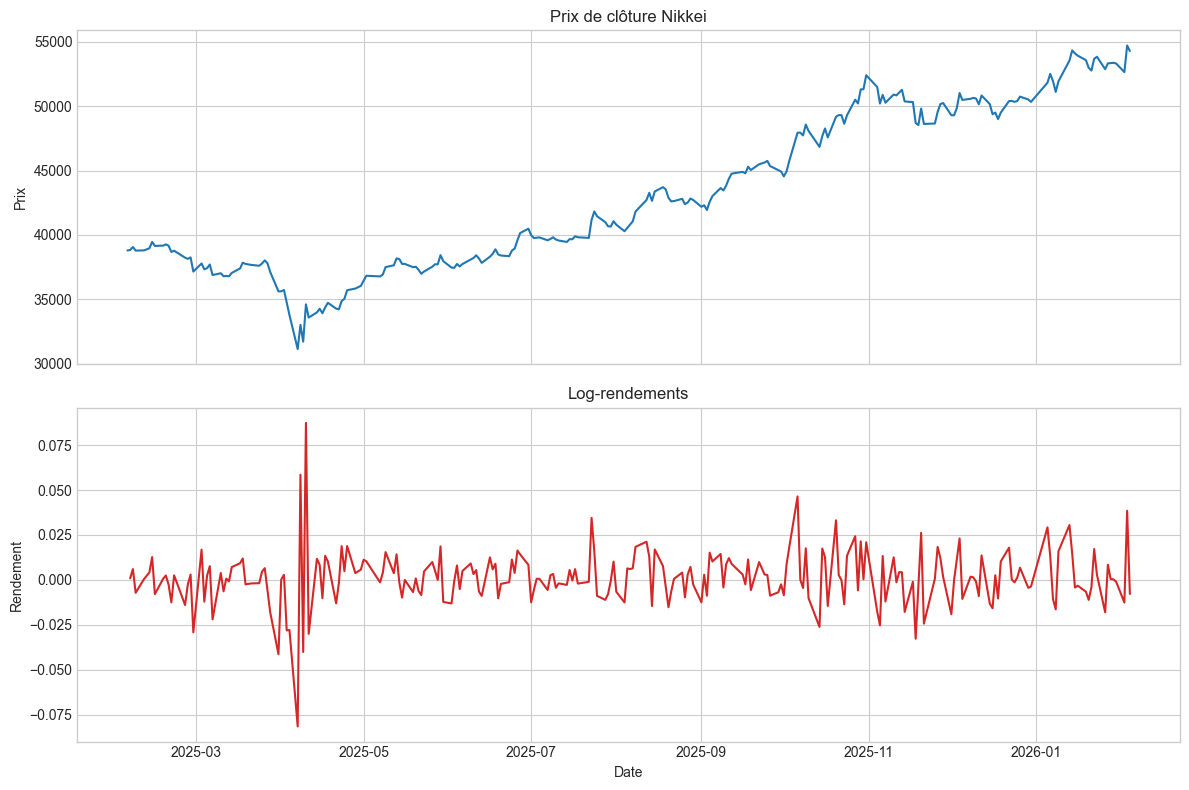

In [7]:
# Visualisation initiale: niveau des prix puis dynamique des rendements.

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].plot(prices.index, prices.values, color="#1f77b4")
axes[0].set_title("Prix de clôture Nikkei")
axes[0].set_ylabel("Prix")

axes[1].plot(log_returns.index, log_returns.values, color="#d62728")
axes[1].set_title("Log-rendements")
axes[1].set_ylabel("Rendement")
axes[1].set_xlabel("Date")

plt.tight_layout()
plt.show()

<!-- auto-doc:run_stationarity_tests -->
### Fonction `run_stationarity_tests`

**Objectif**  
Tester la stationnarité de la série avec ADF et KPSS.

**ADF (H0: racine unitaire, non-stationnaire)**
$$
\Delta x_t = c + \gamma x_{t-1} + \sum_{i=1}^{k} \phi_i\,\Delta x_{t-i} + \varepsilon_t
$$
On teste $H_0: \gamma = 0$.

**KPSS (H0: stationnaire)**
$$
x_t = \xi_t + r_t, \quad r_t = r_{t-1} + u_t
$$
Le test vérifie si la composante aléatoire cumulée est compatible avec la stationnarité (niveau ou tendance selon `regression`).

La fonction compare les p-values au seuil $\alpha$ pour qualifier la cohérence des deux diagnostics.


In [8]:
def run_stationarity_tests(series: pd.Series, regression_adf="c", regression_kpss="c") -> pd.DataFrame:
    
    # Exécute les tests ADF et KPSS puis synthétise les résultats
    
    x = series.dropna()
    if len(x) < 30:
        raise ValueError("Série trop courte pour les tests de stationnarité (min: 30).")

    adf_stat, adf_p, adf_lags, adf_nobs, _, _ = adfuller(
        x,
        regression=regression_adf,
        autolag="AIC",
    )

    with warnings.catch_warnings():
        # Certains jeux de données déclenchent un avertissement d'interpolation KPSS.
        warnings.simplefilter("ignore", InterpolationWarning)
        kpss_stat, kpss_p, kpss_lags, _ = kpss(
            x,
            regression=regression_kpss,
            nlags="auto",
        )

    if adf_p < ALPHA and kpss_p > ALPHA:
        print("Les tests sont cohérents: la série est stationnaire.")
    elif adf_p > ALPHA and kpss_p < ALPHA:
        print("Les tests sont cohérents: la série est non-stationnaire.")
    else:
        print("Les tests sont contradictoires: interprétation incertaine.")

    return pd.DataFrame(
        {
            "test": ["ADF", "KPSS"],
            "stat": [adf_stat, kpss_stat],
            "pvalue": [adf_p, kpss_p],
            "lags": [adf_lags, kpss_lags],
            "h0": [
                "Racine unitaire (non-stationnaire)",
                "Stationnaire",
            ],
        }
    )


stationarity = run_stationarity_tests(log_returns)
stationarity

Les tests sont cohérents: la série est stationnaire.


,test,stat,pvalue,lags,h0
0,ADF,-9.592113,2.023035e-16,2,Racine unitaire (non-stationnaire)
1,KPSS,0.211744,1.000000e-01,6,Stationnaire


<!-- auto-doc:run_dependence_diagnostics -->
### Fonction `run_dependence_diagnostics`

**Objectif**  
Détecter autocorrélation et hétéroscédasticité conditionnelle sur les rendements.

**Ljung-Box (sur $r_t$ puis $r_t^2$)**
$$
Q(m) = n(n+2)\sum_{k=1}^{m} \frac{\hat\rho_k^2}{n-k}
$$
où $\hat\rho_k$ est l'autocorrélation au lag $k$.

**ARCH-LM**
$$
r_t^2 = c + \sum_{i=1}^{m} a_i\,r_{t-i}^2 + u_t
$$
avec $H_0: a_1=\dots=a_m=0$ (absence d'effet ARCH).

La fonction renvoie les tableaux Ljung-Box (rendements et rendements au carré) ainsi que le tableau ARCH-LM.


In [9]:
def run_dependence_diagnostics(series: pd.Series, lags=(5, 10, 20)):
    
    # Teste la dépendance linéaire/non-linéaire et les effets ARCH
    
    x = series.dropna()
    if len(x) <= max(lags):
        raise ValueError("Série trop courte pour les lags demandés.")

    lb_returns = acorr_ljungbox(x, lags=list(lags), return_df=True)
    lb_sq_returns = acorr_ljungbox(x.pow(2), lags=list(lags), return_df=True)

    arch_rows = []
    for lag in lags:
        lm_stat, lm_p, f_stat, f_p = het_arch(x, nlags=lag)
        arch_rows.append(
            {
                "lag": lag,
                "LM stat": lm_stat,
                "LM pvalue": lm_p,
                "F stat": f_stat,
                "F pvalue": f_p,
            }
        )
    arch_lm = pd.DataFrame(arch_rows).set_index("lag")

    if (lb_returns["lb_pvalue"] < ALPHA).any():
        print("Ljung-Box sur rendements: présence de dépendance linéaire.")
    else:
        print("Ljung-Box sur rendements: pas de dépendance linéaire détectée.")

    if (lb_sq_returns["lb_pvalue"] < ALPHA).any():
        print("Ljung-Box sur rendements^2: présence de dépendance non-linéaire.")
    else:
        print("Ljung-Box sur rendements^2: pas de dépendance non-linéaire détectée.")

    if (arch_lm["LM pvalue"] < ALPHA).any():
        print("ARCH-LM: présence d'effets ARCH (hétéroscédasticité conditionnelle).")
    else:
        print("ARCH-LM: pas d'effets ARCH détectés.")

    return lb_returns, lb_sq_returns, arch_lm


lb_r, lb_r2, arch_lm = run_dependence_diagnostics(log_returns)
print("Ljung-Box sur rendements:")
display(lb_r)
print("Ljung-Box sur rendements^2:")
display(lb_r2)
print("ARCH-LM:")
display(arch_lm)


Ljung-Box sur rendements: présence de dépendance linéaire.
Ljung-Box sur rendements^2: présence de dépendance non-linéaire.
ARCH-LM: présence d'effets ARCH (hétéroscédasticité conditionnelle).
Ljung-Box sur rendements:


,lb_stat,lb_pvalue
5,16.743753,0.005012
10,20.737336,0.023001
20,26.945218,0.136812


Ljung-Box sur rendements^2:


,lb_stat,lb_pvalue
5,100.844870,3.507266e-20
10,102.591834,1.648552e-17
20,105.707465,1.182979e-13


ARCH-LM:


,LM stat,LM pvalue,F stat,F pvalue
lag,,,,
5,67.033813,4.239742e-13,18.165058,3.270020e-15
10,74.416988,6.177745e-12,10.398969,2.271499e-14
20,76.233904,1.694580e-08,5.236479,1.632937e-10


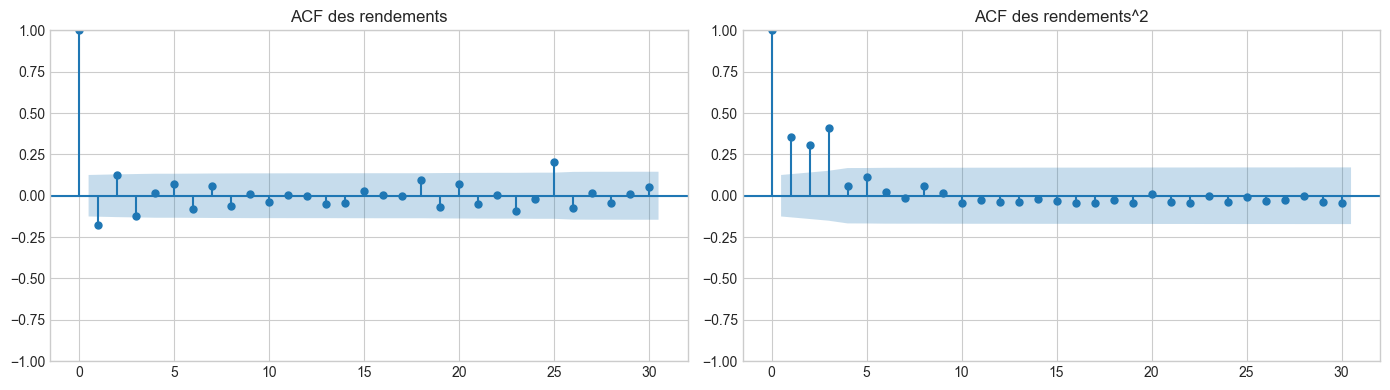

In [10]:
# Contrôle visuel complémentaire de la dépendance (niveau et variance).

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(log_returns, lags=30, ax=axes[0])
axes[0].set_title("ACF des rendements")
plot_acf(log_returns.pow(2), lags=30, ax=axes[1])
axes[1].set_title("ACF des rendements^2")
plt.tight_layout()
plt.show()

<!-- auto-doc:compare_garch_candidates -->
### Fonction `compare_garch_candidates`

**Objectif**  
Estimer plusieurs modèles AR(lag)-GARCH($p,q$)-Student et les comparer.

**Structure du modèle**
$$
r_t = \mu + \sum_{i=1}^{L} \phi_i r_{t-i} + \varepsilon_t, \quad
\varepsilon_t = \sigma_t z_t, \quad z_t \sim t_\nu
$$
$$
\sigma_t^2 = \omega + \sum_{i=1}^{p}\alpha_i\varepsilon_{t-i}^2 + \sum_{j=1}^{q}\beta_j\sigma_{t-j}^2
$$

**Critères retournés**
$$
\text{AIC}=2k-2\ell, \qquad \text{BIC}=k\ln(n)-2\ell
$$
où $k$ est le nombre de paramètres et $\ell$ la log-vraisemblance maximisée.


In [20]:
def compare_garch_candidates(returns: pd.Series, ar_lags=(0, 1, 2), p=1, q=1, dist="t") -> pd.DataFrame:
    """Compare plusieurs spécifications AR(lag)-GARCH(p,q) via AIC/BIC."""
    rows = []
    y = returns.dropna()

    if y.empty:
        raise ValueError("Série vide: impossible de comparer les modèles.")

    for lag in ar_lags:
        mean = "Constant" if lag == 0 else "AR"
        lags_arg = None if lag == 0 else lag

        model = arch_model(
            y,
            mean=mean,
            lags=lags_arg,
            vol="GARCH",
            p=p,
            q=q,
            dist=dist,
            rescale=True,
        )
        fit = model.fit(disp="off")

        rows.append(
            {
                "mean_lag": lag,
                "AIC": fit.aic,
                "BIC": fit.bic,
                "loglik": fit.loglikelihood,
            }
        )

    return pd.DataFrame(rows).sort_values(["BIC", "AIC"]).reset_index(drop=True)


candidates = compare_garch_candidates(log_returns, ar_lags=(0, 1, 2), p=P_ORDER, q=Q_ORDER)
candidates

,mean_lag,AIC,BIC,loglik
0,0,822.291497,839.777338,-406.145749
1,1,822.493018,843.451387,-405.246509
2,2,821.646069,846.068633,-403.823034


In [24]:
# Sélection du meilleur modèle selon le tableau de comparaison (BIC puis AIC)

best_lag = int(candidates.iloc[0]["mean_lag"])
final_mean = "Constant" if best_lag == 0 else "AR"
final_lags = None if best_lag == 0 else best_lag

model = arch_model(
    log_returns,
    mean=final_mean,
    lags=final_lags,
    vol="GARCH",
    p=P_ORDER,
    q=Q_ORDER,
    dist="t",
    rescale=True,
)
fit = model.fit(disp="off")

print(f"Modèle retenu: {final_mean}-GARCH({P_ORDER},{Q_ORDER})")
print(fit.summary())

Modèle retenu: Constant-GARCH(1,1)
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -406.146
Distribution:      Standardized Student's t   AIC:                           822.291
Method:                  Maximum Likelihood   BIC:                           839.777
                                              No. Observations:                  244
Date:                      Sun, Feb 22 2026   Df Residuals:                      243
Time:                              12:33:31   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------

<!-- auto-doc:residual_diagnostics -->
### Fonction `residual_diagnostics`

**Objectif**  
Vérifier si les résidus standardisés du modèle sont proches d'un bruit blanc sans effet ARCH résiduel.

**Résidu standardisé**
$$
z_t = \frac{\hat\varepsilon_t}{\hat\sigma_t}
$$

**Tests appliqués**
- Ljung-Box sur $z_t$ (autocorrélation résiduelle)
- Ljung-Box sur $z_t^2$ (dépendance dans la variance)
- ARCH-LM sur $z_t$ via:
$$
z_t^2 = c + \sum_{i=1}^{m} a_i z_{t-i}^2 + u_t
$$

La fonction renvoie la série des résidus standardisés et les tableaux de tests.


In [ ]:
def residual_diagnostics(fit_result, lags=(5, 10, 20)):

    # Vérifie la qualité des résidus standardisés du modèle ajusté
    
    std_resid = pd.Series(fit_result.std_resid).dropna()
    if len(std_resid) <= max(lags):
        raise ValueError("Pas assez de résidus pour les diagnostics.")

    lb_resid = acorr_ljungbox(std_resid, lags=list(lags), return_df=True)
    lb_resid_sq = acorr_ljungbox(std_resid.pow(2), lags=list(lags), return_df=True)

    arch_rows = []
    for lag in lags:
        lm_stat, lm_p, f_stat, f_p = het_arch(std_resid, nlags=lag)
        arch_rows.append(
            {
                "lag": lag,
                "LM stat": lm_stat,
                "LM pvalue": lm_p,
                "F stat": f_stat,
                "F pvalue": f_p,
            }
        )
    arch_resid = pd.DataFrame(arch_rows).set_index("lag")

    if (lb_resid["lb_pvalue"] < ALPHA).any():
        print("Ljung-Box sur résidus standardisés: dépendance linéaire résiduelle détectée.")
    else:
        print("Ljung-Box sur résidus standardisés: pas de dépendance linéaire résiduelle détectée.")

    if (lb_resid_sq["lb_pvalue"] < ALPHA).any():
        print("Ljung-Box sur résidus^2 standardisés: dépendance non-linéaire résiduelle détectée.")
    else:
        print("Ljung-Box sur résidus^2 standardisés: pas de dépendance non-linéaire résiduelle détectée.")

    if (arch_resid["LM pvalue"] < ALPHA).any():
        print("ARCH-LM sur résidus standardisés: présence d'effets ARCH résiduels.")
    else:
        print("ARCH-LM sur résidus standardisés: pas d'effets ARCH résiduels détectés.")

    return std_resid, lb_resid, lb_resid_sq, arch_resid


std_resid, lb_std, lb_std2, arch_std = residual_diagnostics(fit)
print("Ljung-Box sur résidus:")
display(lb_std)
print("Ljung-Box sur résidus^2:")
display(lb_std2)
print("ARCH-LM sur résidus standardisés:")
display(arch_std)

Ljung-Box sur résidus standardisés: pas de dépendance linéaire résiduelle détectée.
Ljung-Box sur résidus^2 standardisés: pas de dépendance non-linéaire résiduelle détectée.
ARCH-LM sur résidus standardisés: pas d'effets ARCH résiduels détectés.
Ljung-Box sur résidus:


,lb_stat,lb_pvalue
5,1.889653,0.864193
10,4.914382,0.896823
20,13.105382,0.872817


Ljung-Box sur résidus^2:


,lb_stat,lb_pvalue
5,8.802762,0.117195
10,11.222561,0.340443
20,26.091670,0.162806


ARCH-LM sur résidus standardisés:


,LM stat,LM pvalue,F stat,F pvalue
lag,,,,
5,9.161249,0.102803,1.857451,0.102652
10,13.085516,0.218930,1.320905,0.220298
20,25.683035,0.176537,1.314476,0.172634


<!-- auto-doc:engle_ng_sign_bias_test -->
### Fonction `engle_ng_sign_bias_test`

**Objectif**  
Tester une éventuelle asymétrie (effet de signe / taille) dans la variance conditionnelle (test d'Engle-Ng).

**Régression estimée**
$$
z_t^2 = c + b_1 I_{t-1}^- + b_2 I_{t-1}^- z_{t-1} + b_3(1-I_{t-1}^-)z_{t-1} + u_t
$$
avec:
$$
I_{t-1}^- = \mathbf{1}(z_{t-1}<0)
$$

La fonction renvoie la régression OLS et un test joint:
$$
H_0: b_1=b_2=b_3=0
$$


In [26]:
def engle_ng_sign_bias_test(std_resid: pd.Series):

    # Teste l'asymétrie potentielle des chocs (effet de signe/taille)
    
    z = std_resid.dropna()
    z_lag = z.shift(1)
    indicator = (z_lag < 0).astype(int)

    x = pd.DataFrame(
        {
            "const": 1.0,
            "sign_bias": indicator,
            "neg_size_bias": indicator * z_lag,
            "pos_size_bias": (1 - indicator) * z_lag,
        }
    ).dropna()

    y = z.loc[x.index].pow(2)
    reg = sm.OLS(y, x).fit()
    joint_test = reg.f_test("sign_bias = 0, neg_size_bias = 0, pos_size_bias = 0")

    return reg, joint_test


engle_ng_model, engle_ng_joint = engle_ng_sign_bias_test(std_resid)
print(engle_ng_model.summary())
print("Test joint Engle-Ng:")
print(engle_ng_joint)

                            OLS Regression Results                            
Dep. Variable:              std_resid   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6860
Date:                Sun, 22 Feb 2026   Prob (F-statistic):              0.561
Time:                        12:34:26   Log-Likelihood:                -493.69
No. Observations:                 243   AIC:                             995.4
Df Residuals:                     239   BIC:                             1009.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9725      0.263      3.704

<!-- auto-doc:student_t_standardized_tail -->
### Fonction `student_t_standardized_tail`

**Objectif**  
Calculer le quantile de queue gauche et l'Expected Shortfall d'une Student-t standardisée (variance unitaire).

**Étapes de calcul**
1. Quantile brut Student-t:
$$
q_{\alpha}^{\text{raw}} = t_{\nu}^{-1}(\alpha)
$$
2. Standardisation (variance = 1):
$$
s = \sqrt{\frac{\nu-2}{\nu}}, \qquad q_{\alpha}^{\text{std}} = s\,q_{\alpha}^{\text{raw}}
$$
3. ES brut puis standardisé:
$$
ES_{\alpha}^{\text{raw}} = -\frac{\nu + (q_{\alpha}^{\text{raw}})^2}{\nu-1}\cdot\frac{f_{t_\nu}(q_{\alpha}^{\text{raw}})}{\alpha},
\qquad ES_{\alpha}^{\text{std}} = s\,ES_{\alpha}^{\text{raw}}
$$

Condition nécessaire: $\nu>2$ (variance finie).

### Fonction `forecast_var_es_1d`

**Objectif**  
Produire une prévision à un jour de $\mu_{t+1}$, $\sigma_{t+1}$, VaR et ES au niveau $\alpha$.

**Formules utilisées**
$$
\text{VaR}_{t+1,\alpha} = -\big(\mu_{t+1} + \sigma_{t+1} q_{\alpha}^{\text{std}}\big)
$$
$$
\text{ES}_{t+1,\alpha} = -\big(\mu_{t+1} + \sigma_{t+1} ES_{\alpha}^{\text{std}}\big)
$$

Le signe `-` convertit la queue gauche des rendements en mesure de perte positive.


In [ ]:
def student_t_standardized_tail(alpha: float, nu: float) -> tuple[float, float]:
    
    # Calcule quantile VaR et ES de queue gauche pour une Student-t standardisée

    if not (0 < alpha < 1):
        raise ValueError("alpha doit être strictement compris entre 0 et 1.")
    if nu <= 2:
        raise ValueError("nu doit être > 2 pour une variance finie.")

    q_raw = t.ppf(alpha, df=nu)
    scale = np.sqrt((nu - 2) / nu)
    q_std = scale * q_raw

    es_raw = -((nu + q_raw**2) / (nu - 1)) * (t.pdf(q_raw, df=nu) / alpha)
    es_std = scale * es_raw

    return q_std, es_std


def forecast_var_es_1d(fit_result, alpha=0.05):
    
    # Produit la prévision à un jour de la moyenne, volatilité, VaR et ES
    
    forecast = fit_result.forecast(horizon=1, reindex=False)
    mu = float(forecast.mean.iloc[-1, 0])
    sigma = float(np.sqrt(forecast.variance.iloc[-1, 0]))

    nu = float(fit_result.params["nu"])
    q_std, es_std = student_t_standardized_tail(alpha, nu)

    var_1d = -(mu + sigma * q_std)
    es_1d = -(mu + sigma * es_std)

    return {
        "mu_1d": mu,
        "sigma_1d": sigma,
        "nu": nu,
        "VaR_1d": var_1d,
        "ES_1d": es_1d,
    }


risk_1d = forecast_var_es_1d(fit, alpha=ALPHA)
risk_1d

{'mu_1d': 0.13853274124237958,
 'sigma_1d': 1.8517707247889057,
 'nu': 5.780525467743118,
 'VaR_1d': np.float64(2.791372712228204),
 'ES_1d': np.float64(3.9695241343037417)}

<!-- auto-doc:rolling_var_es_garch_t -->
### Fonction `rolling_var_es_garch_t`

**Objectif**  
Backtester VaR/ES en ré-estimant un modèle GARCH-t à chaque date (fenêtre expanding ou rolling).

**Pipeline**
- (Optionnel) mise à l'échelle: $r_t^{(\%)} = 100\,r_t$
- Pour chaque date $t$ (à partir de `start`), estimation du modèle sur l'historique disponible
- Prévision $\mu_{t+1}$, $\sigma_{t+1}$, puis calcul VaR/ES via les formules précédentes

**Indicateur de violation VaR**
$$
\text{hit}_{t+1}^{\text{VaR}} = \mathbf{1}\big(r_{t+1} < -\text{VaR}_{t+1,\alpha}\big)
$$

La sortie contient les réalisations, prévisions de risque, et la liste des estimations ayant échoué (`failed_fits`).


In [29]:
def rolling_var_es_garch_t(
    returns: pd.Series,
    alpha=0.05,
    mean_lags=0,
    p=1,
    q=1,
    start=120,
    window=None,
    scale_to_pct=True,
    disp="off",
):
    # Backteste VaR/ES en ré-estimant un GARCH-t à chaque date de test

    validate_user_inputs(alpha, start, mean_lags, p, q, window)

    r = returns.copy()
    if isinstance(r, pd.DataFrame):
        if r.shape[1] != 1:
            raise ValueError("returns DataFrame doit contenir une seule colonne.")
        r = r.iloc[:, 0]

    r = r.dropna().sort_index()
    if len(r) <= start:
        raise ValueError(
            f"Série trop courte: {len(r)} observations pour start={start}."
        )

    if scale_to_pct:
        r = 100 * r

    rows = []
    failed_fits = []

    for i in range(start, len(r)):

        # Fenêtre d'estimation: expanding par défaut, rolling si `window` est défini

        train = r.iloc[:i] if window is None else r.iloc[max(0, i - window):i]

        try:
            model = arch_model(
                train,
                mean="Constant" if mean_lags == 0 else "AR",
                lags=None if mean_lags == 0 else mean_lags,
                vol="GARCH",
                p=p,
                q=q,
                dist="t",
                rescale=False,
            )
            fit_roll = model.fit(disp=disp)
        except Exception as exc:
            
            # On conserve les erreurs de fit pour audit sans interrompre le backtest

            failed_fits.append((r.index[i], str(exc)))
            continue

        forecast = fit_roll.forecast(horizon=1, reindex=False)
        mu = float(forecast.mean.iloc[-1, 0])
        sigma = float(np.sqrt(forecast.variance.iloc[-1, 0]))
        nu = float(fit_roll.params["nu"])

        q_std, es_std = student_t_standardized_tail(alpha, nu)
        var_1d = -(mu + sigma * q_std)
        es_1d = -(mu + sigma * es_std)

        r_real = float(r.iloc[i])
        hit_var = int(r_real < -var_1d)

        rows.append(
            {
                "date": r.index[i],
                "r_real": r_real,
                "mu_1d": mu,
                "sigma_1d": sigma,
                "nu": nu,
                "VaR_1d": var_1d,
                "ES_1d": es_1d,
                "hit_VaR": hit_var,
            }
        )

    if not rows:
        raise RuntimeError("Aucune prévision produite pendant le backtest.")

    out = pd.DataFrame(rows).set_index("date")
    out.attrs["failed_fits"] = failed_fits
    return out

In [30]:
# Lancement du backtest et synthèse rapide des violations VaR.
df_var = rolling_var_es_garch_t(
    returns=log_returns,
    alpha=ALPHA,
    mean_lags=MEAN_LAGS,
    p=P_ORDER,
    q=Q_ORDER,
    start=BACKTEST_START,
    window=ROLLING_WINDOW,
    scale_to_pct=SCALE_TO_PCT,
)

violations = int(df_var["hit_VaR"].sum())
expected_violations = ALPHA * len(df_var)

display(df_var.tail())
print(f"Nb obs backtest: {len(df_var)}")
print(f"Violations observées: {violations}")
print(f"Violations attendues (~alpha*N): {expected_violations:.2f}")

if df_var.attrs.get("failed_fits"):
    print(f"Fenêtres ignorées (fit échoué): {len(df_var.attrs['failed_fits'])}")


,r_real,mu_1d,sigma_1d,nu,VaR_1d,ES_1d,hit_VaR
date,,,,,,,
2026-01-29,0.031649,0.139045,1.144706,6.245823,1.682083,2.388301,0
2026-01-30,-0.098877,0.137726,1.040550,6.172409,1.516421,2.161319,0
2026-02-02,-1.260033,0.135169,0.979638,6.112200,1.421123,2.030595,0
2026-02-03,3.847672,0.128077,1.194978,6.236132,1.772839,2.510513,0
2026-02-04,-0.783940,0.139459,2.295365,5.860120,3.496103,4.948342,0


Nb obs backtest: 124
Violations observées: 6
Violations attendues (~alpha*N): 6.20


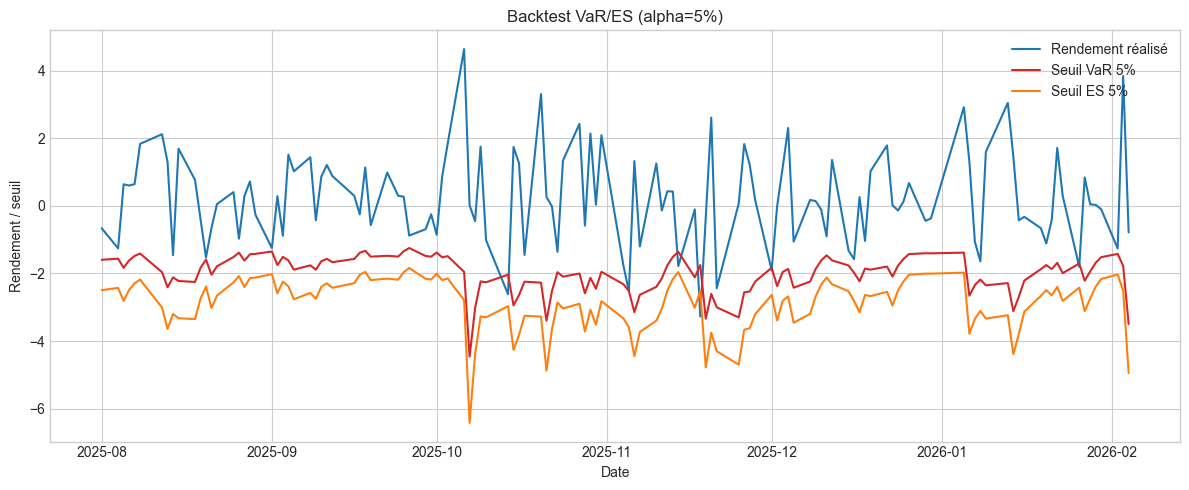

In [31]:
# Représentation conjointe des rendements réalisés et des seuils de risque prévus.
plt.figure(figsize=(12, 5))
plt.title(f"Backtest VaR/ES (alpha={ALPHA:.0%})")
plt.plot(df_var.index, df_var["r_real"], label="Rendement réalisé", color="#1f77b4")
plt.plot(df_var.index, -df_var["VaR_1d"], label=f"Seuil VaR {ALPHA:.0%}", color="#d62728")
plt.plot(df_var.index, -df_var["ES_1d"], label=f"Seuil ES {ALPHA:.0%}", color="#ff7f0e")
plt.xlabel("Date")
plt.ylabel("Rendement / seuil")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
